In [1]:
import numpy as np
import shap
import xgboost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

In [2]:
data1 = pd.read_excel('InputNOutput_Seat_2Span_2Col.xls', sheet_name='Tag_summary')
data1 = data1.iloc[2:]
data1.head()

,Unnamed: 0,ln(X1),ln(X2),ln(X3),ln(X4),ln(X5),ln(X6),ln(X7),ln(X8),ln(X9),...,ln(X18),ln(X19),ln(X20),ln(X21),Y,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27
2,1,-1.76892,2,3.42406,6.15079,3.80603,2.90403,2.06883,-3.67494,6.04694,...,0.0836649,2.3772,1.27827,0.092612,0,NaN,NaN,NaN,NaN,counts
3,2,-0.849313,1,3.61803,6.27968,4.09669,2.87971,1.86966,-4.13065,5.19031,...,0.0190225,2.38097,-0.244324,-0.00992574,2,NaN,NaN,Green,0.0,168
4,3,-0.810957,2,3.2897,6.06654,3.42008,2.85569,2.11903,-3.61052,4.85355,...,0.021253,3.75819,3.56337,-0.0903273,1,NaN,NaN,Yellow,1.0,81
5,4,-1.01444,1,3.24493,6.03941,3.7235,2.85838,2.1065,-3.62457,5.90902,...,0.0594619,2.76136,2.41012,0.17881,2,NaN,NaN,Red,2.0,231
6,5,-1.01397,2,3.44313,6.16308,3.97865,2.98213,1.83201,-4.23109,4.42053,...,-0.00781008,2.89474,2.69792,0.0852726,2,NaN,NaN,NaN,NaN,NaN


In [3]:
#data=data1.loc[:, 'ln(X1)':'ln(X21)', 'Y']

data=data1.loc[:, 'ln(X1)':'Y']
data.head()

,ln(X1),ln(X2),ln(X3),ln(X4),ln(X5),ln(X6),ln(X7),ln(X8),ln(X9),ln(X10),...,ln(X13),ln(X14),ln(X15),ln(X16),ln(X17),ln(X18),ln(X19),ln(X20),ln(X21),Y
2,-1.76892,2,3.42406,6.15079,3.80603,2.90403,2.06883,-3.67494,6.04694,0.25919,...,-1.61169,2,-0.81535,-1.41901,-2.90731,0.0836649,2.3772,1.27827,0.092612,0
3,-0.849313,1,3.61803,6.27968,4.09669,2.87971,1.86966,-4.13065,5.19031,-0.240667,...,-1.98127,2,-1.16175,-1.80196,-2.78804,0.0190225,2.38097,-0.244324,-0.00992574,2
4,-0.810957,2,3.2897,6.06654,3.42008,2.85569,2.11903,-3.61052,4.85355,0.116964,...,-1.99085,2,0.126054,-0.795944,-3.32932,0.021253,3.75819,3.56337,-0.0903273,1
5,-1.01444,1,3.24493,6.03941,3.7235,2.85838,2.1065,-3.62457,5.90902,0.0916618,...,-2.11952,2,-0.168108,-0.952472,-3.16904,0.0594619,2.76136,2.41012,0.17881,2
6,-1.01397,2,3.44313,6.16308,3.97865,2.98213,1.83201,-4.23109,4.42053,-0.236855,...,-1.88036,2,-0.209786,-0.976773,-3.0113,-0.00781008,2.89474,2.69792,0.0852726,2


In [4]:
#One Hot Encoding for the categorical values
data = pd.get_dummies(data = data , columns=['ln(X2)', 'ln(X14)'] )
data.head()

,ln(X1),ln(X3),ln(X4),ln(X5),ln(X6),ln(X7),ln(X8),ln(X9),ln(X10),ln(X11),...,ln(X17),ln(X18),ln(X19),ln(X20),ln(X21),Y,ln(X2)_1,ln(X2)_2,ln(X14)_1,ln(X14)_2
2,-1.76892,3.42406,6.15079,3.80603,2.90403,2.06883,-3.67494,6.04694,0.25919,-0.202621,...,-2.90731,0.0836649,2.3772,1.27827,0.092612,0,0,1,0,1
3,-0.849313,3.61803,6.27968,4.09669,2.87971,1.86966,-4.13065,5.19031,-0.240667,1.1846,...,-2.78804,0.0190225,2.38097,-0.244324,-0.00992574,2,1,0,0,1
4,-0.810957,3.2897,6.06654,3.42008,2.85569,2.11903,-3.61052,4.85355,0.116964,-0.0676165,...,-3.32932,0.021253,3.75819,3.56337,-0.0903273,1,0,1,0,1
5,-1.01444,3.24493,6.03941,3.7235,2.85838,2.1065,-3.62457,5.90902,0.0916618,0.983077,...,-3.16904,0.0594619,2.76136,2.41012,0.17881,2,1,0,0,1
6,-1.01397,3.44313,6.16308,3.97865,2.98213,1.83201,-4.23109,4.42053,-0.236855,1.04207,...,-3.0113,-0.00781008,2.89474,2.69792,0.0852726,2,0,1,0,1


In [5]:
# Generate X and y data
X = data.loc[:, data.columns != 'Y'].to_numpy()
y =data['Y'].to_numpy().astype('int64')

#X.head()

In [6]:
# Split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Isolate our examples for our columns data that have labels
n_labeled_examples = X_train.shape[0]
size = 10 #Intial Samples
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size =20)

In [8]:
training_indices

array([322,  98, 230,  17,  83, 106, 123,  57, 214, 225,  96, 113, 126,
        47,  73,  32, 224, 111, 334, 253])

In [9]:
X_train_new = X_train[training_indices]
y_train_new = y_train[training_indices]

In [10]:
# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_train, training_indices, axis=0)
y_pool = np.delete(y_train, training_indices, axis=0)

In [11]:
from xgboost import XGBClassifier
from modAL.models import ActiveLearner

# Specify the core estimator along with it's active learning model.
XGB = XGBClassifier()
learner = ActiveLearner(estimator=XGB, X_training=X_train_new, y_training=y_train_new)

In [12]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_train)
is_correct = (predictions == y_train)

In [13]:
learner.score(X_train, y_train)

0.7380952380952381

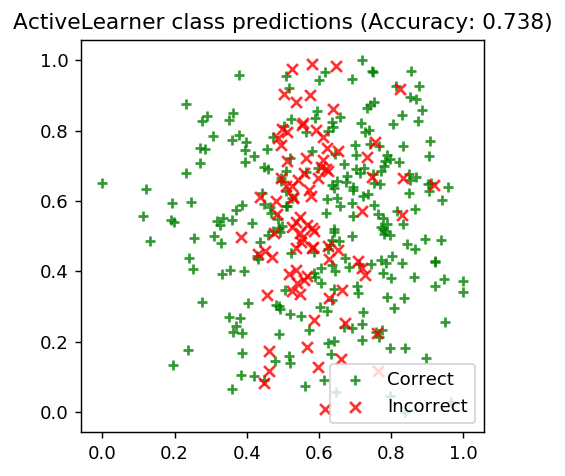

In [14]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_train, y_train)
unqueried_score_test = learner.score(X_test, y_test)


# Plot our classification results.
fig, ax = plt.subplots(figsize=(4, 4), dpi=130)
ax.scatter(x=X_train[is_correct][:,0],  y=X_train[is_correct][:,1],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=X_train[~is_correct][:,0], y=X_train[~is_correct][:,1], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [15]:
learner.query(X_pool)

(array([2], dtype=int64),
 array([[0.56609744, 0.53083305, 0.50861742, 0.51445671, 0.42300348,
         0.63325839, 0.81220984, 0.74103911, 0.28855116, 0.44937379,
         1.        , 0.16253467, 0.41156882, 0.60793748, 0.90222002,
         0.47920354, 0.57447111, 0.93645573, 0.72398959, 1.        ,
         0.        , 1.        , 0.        ]]))

## Random Sampling


Initially the model is trained with 10 random samples. Now we are passing querries one by one. In other words we are tuning the
classifier based on 100 instances (N_QUERIES) that the model hasn't seen before

In [16]:
from random import randrange

#N_QUERIES = len(X_train)-size
N_QUERIES = 100
performance_history = [unqueried_score]
performance_history_test = [unqueried_score_test]
# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
    query_index = randrange(len(X_pool))
    query_instance=X_pool[query_index]
    
    # Teach our ActiveLearner model the record it has requested.
    X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
    learner.teach(X=X, y=y)

    # Remove the queried instance from the unlabeled pool.
    X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

    # Calculate and report our model's accuracy on training data.
    model_accuracy = learner.score(X_train, y_train)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

    # Calculate and report our model's accuracy on training data.
    model_accuracy_test = learner.score(X_test, y_test)

    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)
    performance_history_test.append(model_accuracy_test)

Accuracy after query 1: 0.7530
Accuracy after query 2: 0.6548
Accuracy after query 3: 0.6696
Accuracy after query 4: 0.6726
Accuracy after query 5: 0.6696
Accuracy after query 6: 0.7083
Accuracy after query 7: 0.7083
Accuracy after query 8: 0.7202
Accuracy after query 9: 0.7262
Accuracy after query 10: 0.7143
Accuracy after query 11: 0.7113
Accuracy after query 12: 0.6964
Accuracy after query 13: 0.7292
Accuracy after query 14: 0.7292
Accuracy after query 15: 0.7173
Accuracy after query 16: 0.7232
Accuracy after query 17: 0.7351
Accuracy after query 18: 0.7232
Accuracy after query 19: 0.7321
Accuracy after query 20: 0.7262
Accuracy after query 21: 0.7262
Accuracy after query 22: 0.7202
Accuracy after query 23: 0.7619
Accuracy after query 24: 0.7619
Accuracy after query 25: 0.7649
Accuracy after query 26: 0.7768
Accuracy after query 27: 0.7798
Accuracy after query 28: 0.7708
Accuracy after query 29: 0.7589
Accuracy after query 30: 0.7619
Accuracy after query 31: 0.7560
Accuracy after qu

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


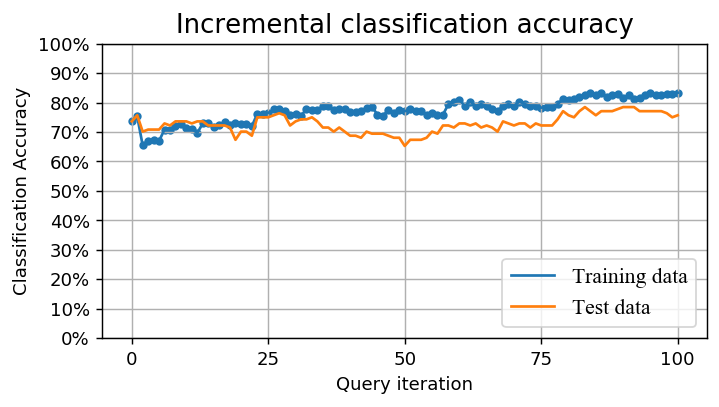

In [17]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(6, 3), dpi=130)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})


ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.plot(performance_history_test)



ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

ax.legend(('Training data', 'Test data'),loc='lower right')
plt.savefig('bridge_random_sampling.eps',format='eps', dpi=1000)
plt.show()

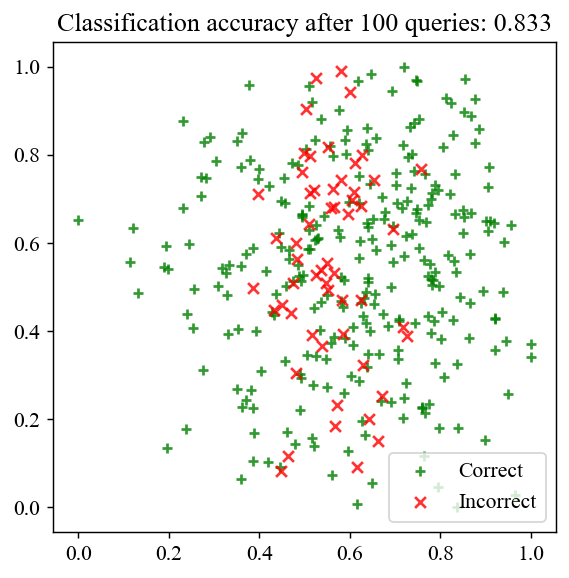

In [18]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_train)
is_correct = (predictions == y_train)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(5, 5), dpi=130)

ax.scatter(x=X_train[is_correct][:,0],  y=X_train[is_correct][:,1],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=X_train[~is_correct][:,0], y=X_train[~is_correct][:,1], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

In [19]:
y_pred_train = learner.predict(X_train)

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_train, y_pred_train)
print(confusion_matrix)

[[103   3   8]
 [ 22  26  11]
 [  4   8 151]]


In [20]:
# Check the performance on training set

print('Accuracy of RF classifier on training set: {:.2f}'
     .format(learner.score(X_train, y_train)))

Accuracy of RF classifier on training set: 0.83


In [21]:
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
print(confusion_matrix_test)

[[47  2  5]
 [ 9  1 12]
 [ 0  7 61]]


In [22]:
# Check the performance on test set

print('Accuracy of RF classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

Accuracy of RF classifier on test set: 0.76
